## Homework №2

### Almost Shakespeare

Let's try to generate some Shakespeare poetry using RNNs. The sonnets file is available in the notebook directory.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


### Data loading

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`).

Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [ ]:
import string
import torch
import random
import numpy as np
from torch import nn
import torch.nn.functional as F
from random import sample
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torch.autograd import Variable

In [ ]:
try:
    with open('../../datasets/Shakespeare_sonnets/sonnets.txt', 'r') as iofile:
        text = iofile.readlines()
except FileNotFoundError:
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt -nc
    with open('sonnets.txt', 'r') as iofile:
        text = iofile.readlines()

--2020-04-26 09:53:30--  https://raw.githubusercontent.com/neychev/made_nlp_course/master/datasets/Shakespeare_sonnets/sonnets.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119747 (117K) [text/plain]
Saving to: ‘sonnets.txt’

sonnets.txt         100%[===================>] 116.94K  --.-KB/s    in 0.01s   

2020-04-26 09:53:30 (9.78 MB/s) - ‘sonnets.txt’ saved [119747/119747]



In [ ]:
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
text = [x.lower() for x in text]
assert len(text) == 2616

In [ ]:
text[:20]

['  from fairest creatures we desire increase,\n',
 "  that thereby beauty's rose might never die,\n",
 '  but as the riper should by time decease,\n',
 '  his tender heir might bear his memory:\n',
 '  but thou, contracted to thine own bright eyes,\n',
 "  feed'st thy light's flame with self-substantial fuel,\n",
 '  making a famine where abundance lies,\n',
 '  thy self thy foe, to thy sweet self too cruel:\n',
 "  thou that art now the world's fresh ornament,\n",
 '  and only herald to the gaudy spring,\n',
 '  within thine own bud buriest thy content,\n',
 "  and tender churl mak'st waste in niggarding:\n",
 '    pity the world, or else this glutton be,\n',
 "    to eat the world's due, by the grave and thee.\n",
 '\n',
 '  ii\n',
 '\n',
 '  when forty winters shall besiege thy brow,\n',
 "  and dig deep trenches in thy beauty's field,\n",
 "  thy youth's proud livery so gazed on now,\n"]

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [ ]:
# Join all the strings into one and lowercase it
# Put result into variable text.
text_2 = ''.join([x.lower() for x in text])

assert len(text_2) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text_2) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [ ]:
tokens = sorted(set(text_2))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [ ]:
# dict <index>:<char>
token_to_idx = {ch:idx for idx, ch in enumerate(tokens)}

# dict <char>:<index>
idx_to_token = {idx:ch for ch, idx in token_to_idx.items()}

In [ ]:
num_tokens = 38

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_idx[' '], dtype='int32', batch_first = True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        line_ix = [token_to_idx[c] for c in names[i]]
        line_ix = line_ix[:max_len]
        names_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()
    hid_state = char_rnn.initial_state()
    logprobs = []

    for x_t in batch_ix.transpose(0,1):
        logp_next, hid_state  = char_rnn(x_t, hid_state)  # <-- here we call your one-step code
        logprobs.append(logp_next)
        
    return torch.stack(logprobs, dim=1)

In [ ]:
class CharRNNModel(nn.Module):
    def __init__(self, num_tokens=num_tokens, embedding_size=32, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.rnn = nn.RNN(embedding_size, rnn_num_units, batch_first=True)
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_state=None):
        x_emb = self.embedding(x.view(1, -1))
        out, h_next = self.rnn(x_emb.view(1, 1, -1), h_state)
        logits = self.rnn_to_logits(out.view(1, -1))
        return logits, h_next
    
    def initial_state(self):
        """ return rnn state before it processes first input (aka h0) """
        return Variable(torch.zeros(1, 1, self.num_units))

In [ ]:
def random_chunk(chunk_len=200):
    start_index = random.randint(0, len(text_2) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text_2[start_index:end_index]

Plot the loss function (axis X: number of epochs, axis Y: loss function).

In [ ]:
def train(model, opt, criterion, chunk_len=200, epochs=2000, num_tokens=num_tokens):
    history = []
    for i in range(epochs):
        batch_ix = to_matrix([random_chunk(chunk_len)])
        batch_ix = torch.tensor(batch_ix, dtype=torch.int64)
        logp_seq = rnn_loop(model, batch_ix)
        # compute loss
        
        loss = criterion(logp_seq[:, :-1].contiguous().view(-1, num_tokens),
                         batch_ix[:, 1:].contiguous().view(-1))
        
        
        # train with backprop
        loss.backward()
        opt.step()
        opt.zero_grad()
        
        history.append(loss.data.numpy())
        if (i+1)%100==0:
            clear_output(True)
            plt.plot(history,label='loss')
            plt.legend()
            plt.show()

    assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

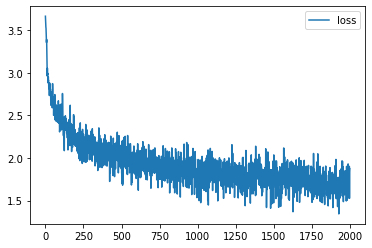

In [ ]:
char_rnn = CharRNNModel()
opt = torch.optim.Adam(char_rnn.parameters())
criterion = nn.CrossEntropyLoss()
train(char_rnn, opt, criterion)

In [ ]:
def generate_sample(char_rnn, seed_phrase=' hello', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs, 
        smaller temperature converges to the single most likely output.
        
    Be careful with the model output. This model waits logits (not probabilities/log-probabilities)
    of the next symbol.
    '''
    
    x_sequence = [token_to_idx[token] for token in seed_phrase]
    x_sequence = torch.tensor(x_sequence, dtype=torch.int64)
    hid_state = char_rnn.initial_state()
    
    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):
        out, hid_state = char_rnn(x_sequence[i], hid_state)
    
    #start generating
    for _ in range(max_length - len(seed_phrase)):
        out, hid_state = char_rnn(x_sequence[-1], hid_state)
        # Be really careful here with the model output
        p_next = F.softmax(out / temperature, dim=-1).data.numpy()[0]
        p_next = p_next.flatten()
        
        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(tokens), p=p_next)
        next_ix = torch.tensor([next_ix], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=0)
        # print(x_sequence)
    
    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()])

In [ ]:
# examples of generated text.
print(generate_sample(char_rnn, seed_phrase="th", max_length=500, temperature=0.8))

the ade this the not shen sey
  to me of beting,
  the graing
  bakes h mould thim cich vanes for on that sulser has dederst that to me dat reser,
  i goond hat i gingter, then nom or fell wile of thou alle sirghed tryse ket eld ard thy things of her to grom sigluy arie,
  moming ir heagut arustind shat thas prowhath wrised asser dour nom thy and hit my meing
  thy my as heartiog thy dound that,
  with noulls thy seepre agrtest thou woll wayes beith seince sumer in of to mean menonger to thing
 


### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

In [ ]:
class CharLSTMModel(nn.Module):
    def __init__(self, num_tokens=num_tokens, embedding_size=32, rnn_num_units=128):
        super(self.__class__, self).__init__()
        self.num_units = rnn_num_units
        self.embedding = nn.Embedding(num_tokens, embedding_size)
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
    
    def forward(self, x, h_state):
        x_emb = self.embedding(x.view(1, -1))
        h_seq, h_next = self.lstm(x_emb.view(1, 1, -1), h_state)
        logits = self.hid_to_logits(h_seq.view(1, -1))
        return logits, h_next
    
    def initial_state(self):
        """ return rnn state before it processes first input (aka h0) """
        return (Variable(torch.zeros(1, 1, self.num_units)), Variable(torch.zeros(1, 1, self.num_units)))

Plot the loss function of the number of epochs. Does the final loss become better?

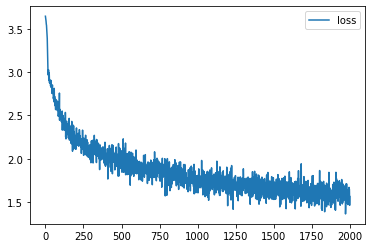

In [ ]:
char_lstm = CharLSTMModel()
opt = torch.optim.Adam(char_lstm.parameters())
criterion = nn.CrossEntropyLoss()
train(char_lstm, opt, criterion, chunk_len=500, epochs=2000)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [ ]:
# examples of generated text.
temperatures = [0.1, 0.2, 0.5, 1.0, 2.0]
for t in temperatures:
    print()
    print('Temperature:', t)
    print(generate_sample(char_lstm, seed_phrase=" ", max_length=500, temperature=t))


Temperature: 0.1
 the see thee thee thee thee,
    and the see the with the see the see the will thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee thee see,
    and the will the prest the see the see the see with thee thee thee thee,
  the with the see the with the see the see thee thee thee thee thee thee thee she love,
  the with the will the see thee the will thee thee thee thee thee thee thee strange.
    the will 

Temperature: 0.2
 then thee thee thee,
  the be the can the love the strange the weet thee dear be thee,
    the will the will the be thee thee thee the with thee me doth thee,
  the prown thee should the sum the see the seet thee thee,
  the will the will the see the were the seet thee,
  the so the will the weet the self thee thee thee thee,
  and they the well and the see the will the seem
  the see the wilt the weet the dear the beauty see,
    the with the weet the will 

**Interpretation of results:**
- The temperature shows how much of randomness in choice we do when generating the sequences of characters. The bigger the value, the more random characters we get next.
- I didn't see any difference in loss results of RNN and LSTM models (even if I increase chunk_size for LSTM model, which potentially could lead to improvement)

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Saving and loading code here
filename = "poem_lstm_model"
torch.save(char_lstm, filename)
model = torch.load(filename)
model.eval()
print(generate_sample(model, seed_phrase=" ", max_length=500, temperature=1))

 gilme.
  and thoe in im heauths wilt wintes gart:
  of they pov'd in giot foosh my self of a tome wrie-.
    fur thee that most knazing gentsed of awige's to mone,
  hif doth from thou beacttry dighine deete;
  which, fiti belose thee brows your so te!
    ar mantieg to groud ascart love, in toke asture,

  cxxl

  did wast howe thees to nad ny but digtus aton me man eis.
    my dever materits and extht plear must;
  i love, they where fors me, you thy true carn.
  reth o! the wines love specze


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch)